<h1 style="text-align: center;">QCNNs for Jet Images Classification</h1>

Motivated by the problem of complex top-quark jet images produced as a result of hypothised BSM particles, this project aims to utilize QML model represented in QCNNs hoping to gain better classification accuracy between the top-quark jet signal and its corresponding QCD background. QCNN architecture was introduced by Cong et al. 2020 and utuilized in various classification tasks in other works showing promising results. 
The coding framework was taken from: https://github.com/ML4SCI/QML-hands-on/blob/main/notebooks/4_QCNN_MNIST.ipynb, and further modified to match the problem at hand.

In [1]:
import pennylane as qml
import pennylane.numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from PIL import Image
import glob
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import os
import sys
from sklearn.metrics import roc_curve, auc
import time

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [2]:
# define number of images, runs, epochs, batch-size, learning rate and optimizor
n_imgs = 1000
exps = 10 
epochs = 10
batch_size = 32
lr = 0.001  
opt = qml.AdamOptimizer(stepsize=lr)

In [3]:
# load jet images and converte size to 28x28 for reasonable PCA reduction (check this)
top_image_list = []
for filename in glob.glob('top/*.png'): 
    im=Image.open(filename).convert('P')
    img=im.resize((28,28))
    top_image_list.append(img)
    
qcd_image_list = []
for filename in glob.glob('qcd/*.png'):
    im=Image.open(filename).convert('P')
    img=im.resize((28,28))
    qcd_image_list.append(img)
    
top_im_num_data = []
for im in top_image_list:    
    numpydata = np.asarray(im)
    top_im_num_data.append(numpydata)

qcd_im_num_data = []
for im in qcd_image_list:    
    numpydata = np.asarray(im)
    qcd_im_num_data.append(numpydata)

In [4]:
# set a label for every class of the images (1: top, 0: qcd)
def generate_dataset(num_images):
    images = []
    labels = []
    
    for n in range(num_images):
        labels.append(1)
        images.append(top_im_num_data[n])
        labels.append(0)                    
        images.append(qcd_im_num_data[n])
    labels = np.array(labels)
    return images, labels

images, labels = generate_dataset(n_imgs) #n_imgs for each class e.g. 1k would give 2k images in total (1k top, 1k QCD)

In [5]:
# split the dataset into train and test sets
(x_train, x_test, y_train, y_test) = train_test_split(images, labels, test_size=0.2, random_state=42)

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

print('x_train.shape:', x_train.shape)
print('y_train.shape:', y_train.shape)
print('x_test.shape:', x_test.shape)
print('y_test.shape:', y_test.shape)

# rescaling pixel values to [0,1]
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

x_train.shape: (1600, 28, 28)
y_train.shape: (1600,)
x_test.shape: (400, 28, 28)
y_test.shape: (400,)


Text(0.5, 1.0, 'Label: 1')

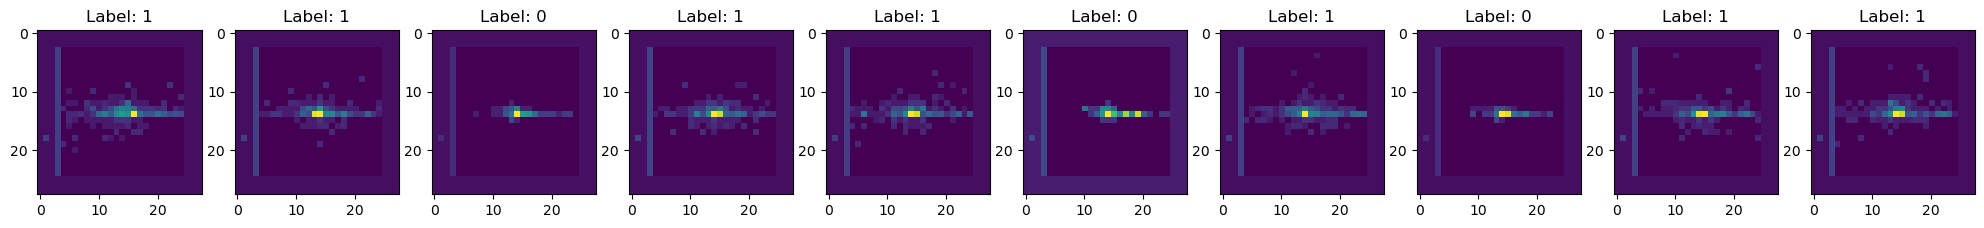

In [6]:
#examples of jet images

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10) = plt.subplots(1,10, figsize=(25, 3))

ax1.imshow(x_train[0,:,:,0]); ax1.set_title(f"Label: {y_train[0]}")

ax2.imshow(x_train[1,:,:,0]); ax2.set_title(f"Label: {y_train[1]}")

ax3.imshow(x_train[2,:,:,0]); ax3.set_title(f"Label: {y_train[2]}")

ax4.imshow(x_train[3,:,:,0]); ax4.set_title(f"Label: {y_train[3]}")

ax5.imshow(x_train[4,:,:,0]); ax5.set_title(f"Label: {y_train[4]}")

ax6.imshow(x_train[5,:,:,0]); ax6.set_title(f"Label: {y_train[5]}")

ax7.imshow(x_train[6,:,:,0]); ax7.set_title(f"Label: {y_train[6]}")

ax8.imshow(x_train[7,:,:,0]); ax8.set_title(f"Label: {y_train[7]}")

ax9.imshow(x_train[8,:,:,0]); ax9.set_title(f"Label: {y_train[8]}")

ax10.imshow(x_train[9,:,:,0]); ax10.set_title(f"Label: {y_train[9]}")

In [7]:
# set the system size and the pca components
n_qubits = 4

#Reducing images size to 2x2
pca = PCA(n_components=n_qubits)
x_train_pca = pca.fit_transform(x_train.reshape(-1, 28 * 28))
x_test_pca = pca.transform(x_test.reshape(-1, 28 * 28))

#Normalizing dataset
norm = np.max(x_train_pca)
x_train_pca = x_train_pca/norm*np.pi
x_test_pca = x_test_pca/norm*np.pi

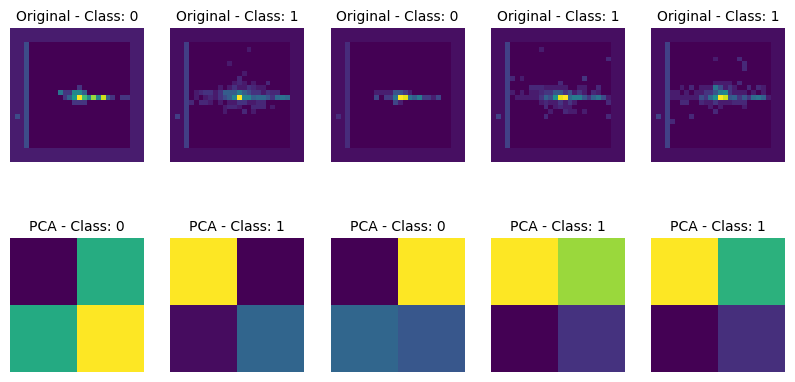

In [8]:
img_height, img_width = 28, 28
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i+5].reshape(img_height, img_width))#, cmap='gray')
    plt.title(f'Original - Class: {y_train[i+5]}', fontsize=10)
    plt.axis('off')

# Visualize the PCA-reduced images
for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(x_train_pca[i+5].reshape(2, 2))#, cmap='gray')
    plt.title(f'PCA - Class: {y_train[i+5]}', fontsize=10)
    plt.axis('off')

plt.show()

In [9]:
# define the quantum device
dev = qml.device('lightning.qubit', wires=n_qubits)

In [10]:
# embedding used to translate classical data to quantum states 
def TPE(data):
  '''
  Tensor Product Embedding
  '''
  for idx, x in enumerate(data):
    qml.RX(x,wires=idx)

def HEE1(data):
    '''
    Hardware Efficient Embdding with 1-layer
    '''
    for idx, x in enumerate(data):
      qml.RX(x,wires=idx)
    for idx in range(n_qubits-1):
      qml.CNOT(wires=[idx,idx+1])
      
def HEE2(data):
    '''
    Hardware Efficient Embdding with 2-layers
    '''
    for idx, x in enumerate(data):
      qml.RX(x,wires=idx)
    for idx in range(n_qubits-1):
      qml.CNOT(wires=[idx,idx+1])
    for idx, x in enumerate(data):
      qml.RX(x,wires=idx)
    for idx in range(n_qubits-1):
      qml.CNOT(wires=[idx,idx+1])
            
      
def CHE(data):
    '''
    Classically Hard to simulate Embdding with 1-layer
    '''
    x1 = 0
    x2 = 0
    x3 = 0
    x4 = 0
    for idx, x in enumerate(data):
      qml.Hadamard(wires=idx)
      qml.RZ(x,wires=idx)
    #for idx in range(n_qubits-1):
    for idx, x in enumerate(data):
      if idx == 0:
        x1 = x
      if idx == 1: 
        x2 = x
      if idx == 2:
        x3 = x
      if idx == 3:
        x4 = x
    for idx in range(n_qubits-1):
      if idx==(n_qubits-4): #idx=0
        qml.CNOT(wires=[idx,idx+1]) 
        qml.RZ(x1*x2, wires=idx+1)
        qml.CNOT(wires=[idx,idx+1])
      if idx==(n_qubits-3): #idx=1
        qml.CNOT(wires=[idx,idx+1]) 
        qml.RZ(x3*x2, wires=idx+1)
        qml.CNOT(wires=[idx,idx+1])   
      if idx==(n_qubits-2): #idx=2
        qml.CNOT(wires=[idx,idx+1]) 
        qml.RZ(x3*x4, wires=idx+1)
        qml.CNOT(wires=[idx,idx+1])
        qml.CNOT(wires=[idx-2,idx+1])
        qml.RZ(x1*x4, wires=idx+1)
        qml.CNOT(wires=[idx-2,idx+1])
        qml.CNOT(wires=[idx-1,idx+1])
        qml.RZ(x2*x4, wires=idx+1)
        qml.CNOT(wires=[idx-1,idx+1])

In [11]:
Enc = HEE1

In [12]:
#pooling circuit obtained from https://github.com/ML4SCI/QML-hands-on/blob/main/notebooks/4_QCNN_MNIST.ipynb      
def pool(sinkbit, targetbit, params):
    #qml.Rot(params[0], params[1], params[2], wires=sinkbit)
    qml.RZ(params[0], wires=sinkbit)
    qml.RY(params[1], wires=sinkbit)
    qml.RZ(params[2], wires=sinkbit)
    #qml.Rot(params[3], params[4], params[5], wires=targetbit)
    qml.RZ(params[3], wires=targetbit)
    qml.RY(params[4], wires=targetbit)
    qml.RZ(params[5], wires=targetbit)
    qml.CNOT(wires=[sinkbit,targetbit])
    #qml.Rot(params[6], params[7], params[8], wires=targetbit)
    qml.RZ(params[6], wires=targetbit)
    qml.RY(params[7], wires=targetbit)
    qml.RZ(params[8], wires=targetbit)


In [13]:
#SO4 convolutional circuit
def conv_so4(q0, q1, params):
    qml.RZ(np.pi/4, wires=q0)
    qml.RZ(np.pi/4, wires=q1)
    qml.RY(np.pi/2, wires=q1)
    qml.CNOT(wires=[q1,q0])
    qml.Rot(params[0], params[1], params[2], wires=q0)
    qml.Rot(params[3], params[4], params[5], wires=q1)
    qml.CNOT(wires=[q1,q0])
    qml.RY(-np.pi/2, wires=q1)
    qml.RZ(-np.pi/4, wires=q1)
    qml.RZ(-np.pi/4, wires=q0)
    
#SU4 convolutional circuit
def conv_su4(q0, q1, params):
    qml.RZ(params[0], wires=q1)
    qml.CNOT(wires=[q0,q1])
    qml.RZ(params[1], wires=q0)
    qml.RX(params[2], wires=q0)
    qml.RZ(params[3], wires=q0)
    qml.RZ(params[4], wires=q1)
    qml.RX(params[5], wires=q1)
    qml.RZ(params[6], wires=q1)
    qml.CNOT(wires=[q0,q1])
    qml.RX(params[7], wires=q0)
    qml.RZ(params[8], wires=q1)
    qml.CNOT(wires=[q0,q1])
    qml.RZ(params[9], wires=q0)
    qml.RX(params[10], wires=q0)
    qml.RZ(params[11], wires=q0)
    qml.RZ(params[12], wires=q1)
    qml.RX(params[13], wires=q1)
    qml.RZ(params[14], wires=q1)
    


In [14]:
# DEA circuits:

#so4_dea
def conv2_so4_dea(qubit0, qubit1, params):
    qml.RZ(np.pi/4, wires=qubit0)
    qml.RZ(np.pi/4, wires=qubit1)
    qml.RY(np.pi/2, wires=qubit1)
    qml.CNOT(wires=[qubit1,qubit0])
    qml.Rot(params[0], params[1], params[2], wires=qubit0)
    #qml.RZ(params[3],wires=qubit1)
    qml.RY(params[3],wires=qubit1)
    qml.RY(params[4],wires=qubit1)
    qml.CNOT(wires=[qubit1,qubit0])
    qml.RY(-np.pi/2, wires=qubit1)
    qml.RZ(-np.pi/4, wires=qubit1)
    qml.RZ(-np.pi/4, wires=qubit0)
    
def pool6p_so4_dea(sinkbit, targetbit, params):
    qml.RZ(params[0],wires=sinkbit)
    qml.RY(params[1],wires=sinkbit)
    qml.RZ(params[2],wires=targetbit)
    qml.RY(params[3],wires=targetbit)
    qml.CNOT(wires=[sinkbit,targetbit])
    qml.RZ(params[4],wires=targetbit)
    qml.RY(params[5],wires=targetbit)
    
    
#su4_dea
def conv2_su4_dea(qubit0, qubit1, params):
    qml.RZ(params[0], wires=qubit1)
    qml.CNOT(wires=[qubit0,qubit1])
    qml.RX(params[1], wires=qubit0)
    qml.RZ(params[2], wires=qubit0)
    qml.RZ(params[3], wires=qubit1)
    qml.RX(params[4], wires=qubit1)
    qml.RZ(params[5], wires=qubit1)
    qml.CNOT(wires=[qubit0,qubit1])
    qml.RX(params[6], wires=qubit0)
    #qml.RX(params[6], wires=qubit1)
    qml.RZ(params[7], wires=qubit1)
    qml.CNOT(wires=[qubit0,qubit1])
    
def pool8p(sinkbit, targetbit, params):
    qml.Rot(params[0], params[1], params[2], wires=sinkbit)
    qml.Rot(params[3], params[4], params[5], wires=targetbit)
    qml.CNOT(wires=[sinkbit,targetbit])
    qml.RZ(params[6],wires=targetbit)
    qml.RY(params[7],wires=targetbit)
    

In [15]:
#so4 model
def layer_so4(params, wires):
    for idx, wire in enumerate(wires):
        if idx % 2 == 0:
            conv_so4(wire, wire+1, params[:6])
    for idx, wire in enumerate(wires):
        if idx % 2 == 1 and not idx == len(wires)-1:
            conv_so4(wire, wire+1, params[:6])

    for idx, wire in enumerate(wires[:int(len(wires)/2)]):
        pool(wire, wire+int(len(wires)/2), params[6:15])

def model_pqc_so4(params):
    layer_so4(params[:15], wires=range(n_qubits))
    layer_so4(params[15:30], wires=[2,3])
    
@qml.qnode(dev)
def training_circuit_so4(data, params, wires):
  Enc(data)
  model_pqc_so4(params)
  return qml.expval(qml.PauliZ(wires[-1]))

In [16]:
#su4 model
def layer_su4(params, wires):
    for idx, wire in enumerate(wires):
        if idx % 2 == 0:
            conv_su4(wire, wire+1, params[:15])
    for idx, wire in enumerate(wires):
        if idx % 2 == 1 and not idx == len(wires)-1:
            conv_su4(wire, wire+1, params[:15])

    for idx, wire in enumerate(wires[:int(len(wires)/2)]):
        pool(wire, wire+int(len(wires)/2), params[15:24])

def model_pqc_su4(params):
    layer_su4(params[:24], wires=range(n_qubits))
    layer_su4(params[24:48], wires=[2,3])

@qml.qnode(dev)
def training_circuit_su4(data, params, wires):
    Enc(data)
    model_pqc_su4(params)
    return qml.expval(qml.PauliZ(wires[-1]))

In [17]:
#so4 DEA model 
def layer1_so4DEA(params, wires):
    for idx, wire in enumerate(wires):
        if idx % 2 == 0:
            conv_so4(wire, wire+1, params[:6])
    for idx, wire in enumerate(wires):
        if idx % 2 == 1 and not idx == len(wires)-1:
            conv_so4(wire, wire+1, params[:6])

    for idx, wire in enumerate(wires[:int(len(wires)/2)]):
        pool8p(wire, wire+int(len(wires)/2), params[6:14])

def layer2_so4DEA(params, wires):
    for idx, wire in enumerate(wires):
        if idx % 2 == 0:
            conv2_so4_dea(wire, wire+1, params[:5])
    for idx, wire in enumerate(wires):
        if idx % 2 == 1 and not idx == len(wires)-1:
            conv2_so4_dea(wire, wire+1, params[:5])

    for idx, wire in enumerate(wires[:int(len(wires)/2)]):
        pool6p_so4_dea(wire, wire+int(len(wires)/2), params[5:11])
        
def model_pqc_so4_dea25p(params):
    layer1_so4DEA(params[:14], wires=range(n_qubits))
    layer2_so4DEA(params[14:25], wires=[2,3])


In [18]:

#su4 DEA model
def layer1_su4_dea(params, wires):
    for idx, wire in enumerate(wires):
        if idx % 2 == 0:
            conv_su4(wire, wire+1, params[:15])
    for idx, wire in enumerate(wires):
        if idx % 2 == 1 and not idx == len(wires)-1:
            conv_su4(wire, wire+1, params[:15])

    for idx, wire in enumerate(wires[:int(len(wires)/2)]):
        pool8p(wire, wire+int(len(wires)/2), params[15:23])

def layer2_8p(params, wires):
    for idx, wire in enumerate(wires):
        if idx % 2 == 0:
            conv2_su4_dea(wire, wire+1, params[:8])
    for idx, wire in enumerate(wires):
        if idx % 2 == 1 and not idx == len(wires)-1:
            conv2_su4_dea(wire, wire+1, params[:8])

def model_pqc_su4_dea(params):
    layer1_su4_dea(params[:23], wires=range(n_qubits))
    layer2_8p(params[23:31], wires=[2,3])

@qml.qnode(dev)
def training_circuit_su4_dea(data, params, wires):
    Enc(data)
    model_pqc_su4_dea(params)
    return qml.expval(qml.PauliZ(wires[-1]))

In [19]:
# choose the circuit model and the corresponding number of parameters
#training_circuit = training_circuit_so4
#n_params = 30

training_circuit = training_circuit_su4_dea
n_params = 31

In [20]:
# define the loss function and the accuracy metric
#MSE loss
def loss_mse(batch_x, batch_y, params, wires):
    mse_loss = 0
    for idx, x in enumerate(batch_x):
        y_pred = training_circuit(x, params, wires)
        mse_loss += (batch_y[idx] - y_pred)**2
    return mse_loss / len(batch_x)

def accuracy_mse(dataX, dataY, params, wires): #mse here refers to the labels of -1 and 1
    acc = 0
    pred = 0
    for idx, x in enumerate(dataX):
        if training_circuit(x, params, wires) < 0:
            pred = -1 
        else:
            pred = 1
        if pred == dataY[idx]: 
            acc += 1
    return acc / len(dataX)

loss_QCNN = loss_mse

In [21]:
#divide dataset into minibatches
def iterate_minibatches(dataX, dataY, batch_size):
    for start_idx in range(0, dataX.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield dataX[idxs], dataY[idxs]

<frozen _collections_abc>:949: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
<frozen _collections_abc>:949: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
<frozen _collections_abc>:949: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
<frozen _collections_abc>:949: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
<frozen _collections_abc>:949: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


(<Figure size 4400x500 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x3292e9a90>)

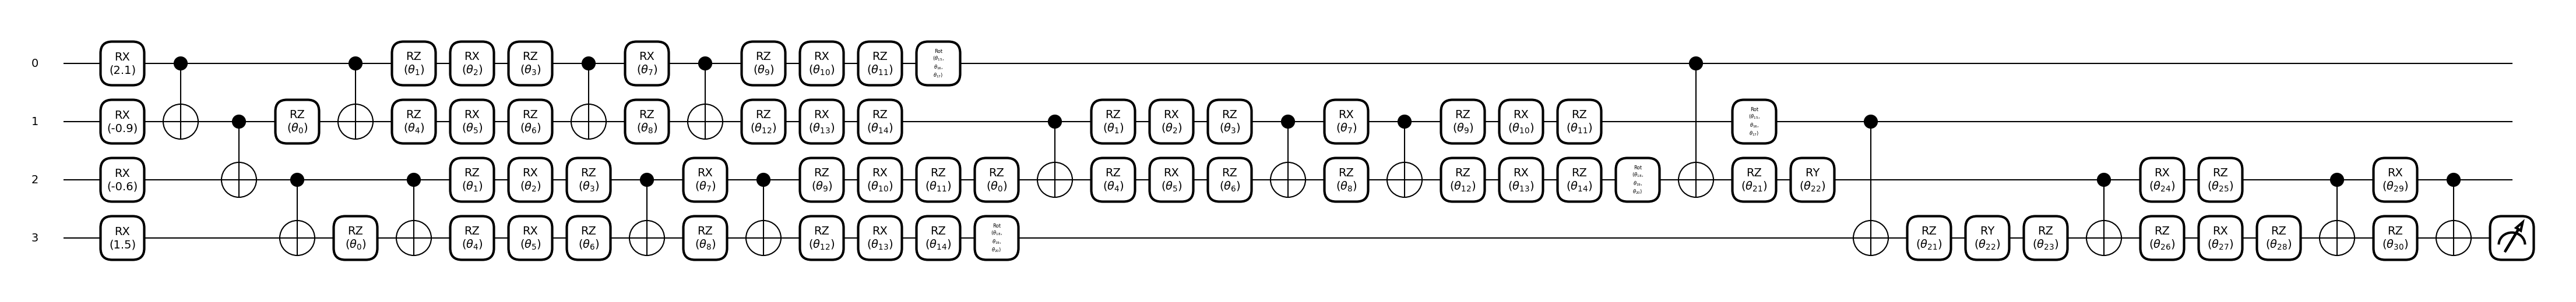

In [22]:
# draw the circuit
theta_strings = [rf'$\theta_{{{i}}}$' for i in range(n_params)]
qml.draw_mpl(training_circuit, decimals=1)(x_train_pca[0], theta_strings, range(n_qubits))
#plt.savefig(os.path.join(directory, f'{training_circuit.__name__}.png'), format="png", dpi=300)

In [23]:
qrange = range(n_qubits)
Time_per_run = []

#Running the QCNN and CNN models over different experiments
for i in range(exps):
    #Initializing random parameters at each run
    #t = 1000 * time.time() # current time in milliseconds
    #np.random.seed(int(t) % 2**32)
    params = np.array(np.random.uniform(size=n_params), requires_grad=True)*np.pi
    print('params=', params)

    start = time.time()

    # Scaling y_train and y_test from [0, 1] to [-1, +1]
    y_train_qcnn = 2 * y_train - 1
    y_test_qcnn = 2 * y_test - 1
        
    acc_list_train = []
    loss_list_train = []
    acc_list_test = []
    loss_list_test = []

    
    #running over different iterations
    for it in range(epochs):
        for j,data in enumerate(iterate_minibatches(x_train_pca, y_train_qcnn, batch_size=batch_size)):
            Xbatch, Ybatch = data
            cost_fn = lambda p: loss_QCNN(Xbatch, Ybatch, p, wires=qrange)
            params = opt.step(cost_fn, params)
            print(j, end="\r")
        
        
        #loss_val = loss_QCNN(x_train, y_train, params, wires=qrange) 
        #loss_list_train.append(loss_val)
        acc = accuracy_mse(x_train_pca, y_train_qcnn, params, wires=qrange)
        acc_list_train.append(acc)
        
        #loss_val_test = loss_QCNN(x_test, y_test, params, wires=qrange)
        #loss_list_test.append(loss_val_test)
        acc_test = accuracy_mse(x_test_pca, y_test_qcnn, params, wires=qrange)
        acc_list_test.append(acc_test)

        print(f"Run {i}, Epoch: {it} | acc: {acc:.3} ")
        print("____")
        print(f"Run {i}, Epoch: {it} | acc (test): {acc_test:.3} ")
        print("____")

    end = time.time()
    
    Time_per_run.append(end - start)
    

    print(f"Time for {epochs} epochs: {end - start}")
    
    def predict_proba_QCNN(X, params, wires):
            scores = []
            for x in X:
                score = training_circuit(x, params, wires)  # Replace with your actual forward pass
                scores.append(score)
            return np.array(scores)

    # Get QCNN predictions
    y_score_qcnn = predict_proba_QCNN(x_test_pca, params, wires=range(n_qubits))
    

    #if loss_QCNN == loss_mse or loss_QCNN == loss_hing:
    #Scaling y_train and y_test from [-1, +1] to [0, 1]
    # y_train_cnn = (y_train + 1)/ 2
    # y_test_cnn = (y_test + 1)/ 2
    
    y_train_cnn = y_train
    y_test_cnn = y_test


    x_train_pca_reshaped = x_train_pca.reshape(-1, 2, 2, 1)
    x_test_pca_reshaped = x_test_pca.reshape(-1, 2, 2, 1)

    activationCNN='sigmoid'
    loss_CNN='MSE'


    #Defining the CNN model
    model = keras.Sequential([
        keras.layers.Input(shape=(2, 2, 1)),
        keras.layers.Conv2D(4, (2, 2), activation='relu', padding='same'), #remember: this is consistent with DEA circuit, not full QCNN
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(2, activation='relu'), #change 2 to 5 to get 51 parameters
        keras.layers.Dense(1, activation=activationCNN)
    ])

    #Compiling the model
    model.compile(optimizer='adam',
                loss=loss_CNN,
                metrics=['accuracy'])


    acc = []
    val_acc = []
    loss = []
    val_loss = []


    #Train the model
    history = model.fit(x_train_pca_reshaped, y_train_cnn, epochs=epochs, batch_size=batch_size, validation_data=(x_test_pca_reshaped, y_test_cnn))
        

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    #loss = history.history['loss']
    #val_loss = history.history['val_loss']
        
        

    directory = f'QCNNvsCNN_AllModels_{loss_QCNN.__name__}_{training_circuit.__name__}'
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    y_score_cnn = model.predict(x_test_pca_reshaped).flatten()
        
        
    Nrun = 0
    

    # Save accuracy and loss results to text files
    np.savetxt(os.path.join(directory, f'accuracy_results_SU4_{loss_QCNN.__name__}_DEA_run{i+Nrun}.txt'), np.vstack((acc_list_train, acc_list_test, acc, val_acc)).T, header='Mean_Train_Accuracy Mean_Test_Accuracy CNN_Train_Accuracy CNN_Test_Accuracy', comments='')
    #np.savetxt(os.path.join(directory, f'loss_results_SU4_{loss_QCNN.__name__}_{Enc.__name__}_DEA_run{i+Nrun}.txt'), np.vstack((loss_list_train, loss_list_test, loss, val_loss)).T, header='Mean_Train_Loss Mean_Test_Loss CNN_Train_Loss CNN_Test_Loss', comments='')
    np.savetxt(os.path.join(directory, f'roc_results_SO4_{loss_QCNN.__name__}_HEE1_run{i+Nrun}.txt'), np.vstack((y_score_qcnn, y_score_cnn)).T, header='ROC_score_QCNN ROC_score_CNN', comments='')
    np.savetxt(os.path.join(directory, f'time_results_SU4_{loss_QCNN.__name__}_DEA_run{i+Nrun}.txt'), np.vstack((Time_per_run)).T, header='Time/run', comments='')
    np.savetxt(os.path.join(directory, f'final_params_SU4_{loss_QCNN.__name__}_DEA_run{i+Nrun}.txt'), np.vstack((params)).T, header='Final Params', comments='')



params= [1.49957763 2.7543522  2.74221768 0.64088435 1.27019001 2.49432829
 0.76393373 3.13228208 0.94098476 0.32650569 1.07972155 1.63911294
 2.7260237  2.2438403  2.98440835 0.07582661 2.35082383 2.6357489
 2.88161705 2.59981072 1.42833724 2.40473574 0.58343003 2.2854095
 1.5090778  2.46280211 0.53849598 1.02863275 1.89646091 0.24346787
 2.41492147]
Run 0, Epoch: 0 | acc: 0.568 
____
Run 0, Epoch: 0 | acc (test): 0.555 
____
Run 0, Epoch: 1 | acc: 0.756 
____
Run 0, Epoch: 1 | acc (test): 0.728 
____
Run 0, Epoch: 2 | acc: 0.892 
____
Run 0, Epoch: 2 | acc (test): 0.877 
____
Run 0, Epoch: 3 | acc: 0.948 
____
Run 0, Epoch: 3 | acc (test): 0.925 
____
Run 0, Epoch: 4 | acc: 0.961 
____
Run 0, Epoch: 4 | acc (test): 0.955 
____
Run 0, Epoch: 5 | acc: 0.974 
____
Run 0, Epoch: 5 | acc (test): 0.97 
____
Run 0, Epoch: 6 | acc: 0.988 
____
Run 0, Epoch: 6 | acc (test): 0.983 
____
Run 0, Epoch: 7 | acc: 0.994 
____
Run 0, Epoch: 7 | acc (test): 0.993 
____
Run 0, Epoch: 8 | acc: 0.996 
_

In [24]:
#import numpy as np
import matplotlib.pyplot as plt

runs = exps
suffixes = ['HEE1']
losses = ['mse']#['hing', 'mse', 'xent']

data = {}
accuracy_data = {}
loss_data = {}
roc_data = {}

for loss in losses:
    accuracy_data[f'accuracy_data_{loss}_Enc'] = {}
    #loss_data[f'loss_data_{loss}_Enc'] = {}
    roc_data[f'roc_data_{loss}_Enc'] = {}

    for suffix in suffixes:
        accuracy_data[f'accuracy_data_{loss}_Enc'][suffix] = []
        #loss_data[f'loss_data_{loss}_Enc'][suffix] = []
        roc_data[f'roc_data_{loss}_Enc'][suffix] = []

    for suffix in suffixes:
        for run in range(runs):
            accuracy_data[f'accuracy_data_{loss}_Enc'][suffix].append(np.loadtxt(f'QCNNvsCNN_AllModels_{loss_QCNN.__name__}_{training_circuit.__name__}/accuracy_results_SU4_{loss_QCNN.__name__}_DEA_run{run}.txt', skiprows=1))
            #loss_data[f'loss_data_{loss}_Enc'][suffix].append(np.loadtxt(f'QCNNvsCNN_SO4_loss_{loss}_embedding_{suffix}_SimpCirc_ROC/loss_results_SO4_loss_{loss}_embedding_{suffix}_run{run}.txt', skiprows=1))
            roc_data[f'roc_data_{loss}_Enc'][suffix].append(np.loadtxt(f'QCNNvsCNN_AllModels_{loss_QCNN.__name__}_{training_circuit.__name__}/roc_results_SO4_loss_{loss}_{suffix}_run{run}.txt', skiprows=1))


    for suffix in suffixes:
        data[f'acc_train_{loss}_{suffix}_QCNN_AllRuns'] = []
        data[f'acc_test_{loss}_{suffix}_QCNN_AllRuns'] = []
        data[f'acc_train_{loss}_{suffix}_CNN_AllRuns'] = []
        data[f'acc_test_{loss}_{suffix}_CNN_AllRuns'] = []
        # data[f'loss_train_{loss}_{suffix}_QCNN_AllRuns'] = []
        # data[f'loss_test_{loss}_{suffix}_QCNN_AllRuns'] = []
        # data[f'loss_train_{loss}_{suffix}_CNN_AllRuns'] = []
        # data[f'loss_test_{loss}_{suffix}_CNN_AllRuns'] = []
        
        data[f'roc_{loss}_{suffix}_QCNN_AllRuns'] = []
        data[f'roc_{loss}_{suffix}_CNN_AllRuns'] = []

    for suffix in suffixes:
        for i in range(len(accuracy_data[f'accuracy_data_{loss}_Enc'][suffix])):
            data[f'acc_train_{loss}_{suffix}_QCNN_AllRuns'].append(accuracy_data[f'accuracy_data_{loss}_Enc'][suffix][i][:, 0])
            data[f'acc_test_{loss}_{suffix}_QCNN_AllRuns'].append(accuracy_data[f'accuracy_data_{loss}_Enc'][suffix][i][:, 1])
            data[f'acc_train_{loss}_{suffix}_CNN_AllRuns'].append(accuracy_data[f'accuracy_data_{loss}_Enc'][suffix][i][:, 2])
            data[f'acc_test_{loss}_{suffix}_CNN_AllRuns'].append(accuracy_data[f'accuracy_data_{loss}_Enc'][suffix][i][:, 3])
            # data[f'loss_train_{loss}_{suffix}_QCNN_AllRuns'].append(loss_data[f'loss_data_{loss}_Enc'][suffix][i][:, 0])
            # data[f'loss_test_{loss}_{suffix}_QCNN_AllRuns'].append(loss_data[f'loss_data_{loss}_Enc'][suffix][i][:, 1])
            # data[f'loss_train_{loss}_{suffix}_CNN_AllRuns'].append(loss_data[f'loss_data_{loss}_Enc'][suffix][i][:, 2])
            # data[f'loss_test_{loss}_{suffix}_CNN_AllRuns'].append(loss_data[f'loss_data_{loss}_Enc'][suffix][i][:, 3])
            
            data[f'roc_{loss}_{suffix}_QCNN_AllRuns'].append(roc_data[f'roc_data_{loss}_Enc'][suffix][i][:, 0])
            data[f'roc_{loss}_{suffix}_CNN_AllRuns'].append(roc_data[f'roc_data_{loss}_Enc'][suffix][i][:, 1])
            
mean_data = {}
std_data = {}

for loss in losses:
    for suffix in suffixes:
        mean_data[f'mean_acc_train_{loss}_{suffix}_QCNN_AllRuns'] = []
        mean_data[f'mean_acc_test_{loss}_{suffix}_QCNN_AllRuns'] = []
        mean_data[f'mean_acc_train_{loss}_{suffix}_CNN_AllRuns'] = []
        mean_data[f'mean_acc_test_{loss}_{suffix}_CNN_AllRuns'] = []
        # mean_data[f'mean_loss_train_{loss}_{suffix}_QCNN_AllRuns'] = []
        # mean_data[f'mean_loss_test_{loss}_{suffix}_QCNN_AllRuns'] = []
        # mean_data[f'mean_loss_train_{loss}_{suffix}_CNN_AllRuns'] = []
        # mean_data[f'mean_loss_test_{loss}_{suffix}_CNN_AllRuns'] = []
        
        mean_data[f'mean_roc_{loss}_{suffix}_QCNN_AllRuns'] = []
        mean_data[f'mean_roc_{loss}_{suffix}_CNN_AllRuns'] = []


        mean_data[f'mean_acc_train_{loss}_{suffix}_QCNN_AllRuns'] = np.mean(data[f'acc_train_{loss}_{suffix}_QCNN_AllRuns'], axis=0)
        mean_data[f'mean_acc_test_{loss}_{suffix}_QCNN_AllRuns'] = np.mean(data[f'acc_test_{loss}_{suffix}_QCNN_AllRuns'], axis=0)
        mean_data[f'mean_acc_train_{loss}_{suffix}_CNN_AllRuns'] = np.mean(data[f'acc_train_{loss}_{suffix}_CNN_AllRuns'], axis=0)
        mean_data[f'mean_acc_test_{loss}_{suffix}_CNN_AllRuns'] = np.mean(data[f'acc_test_{loss}_{suffix}_CNN_AllRuns'], axis=0)
        # mean_data[f'mean_loss_train_{loss}_{suffix}_QCNN_AllRuns'] = np.mean(data[f'loss_train_{loss}_{suffix}_QCNN_AllRuns'], axis=0)
        # mean_data[f'mean_loss_test_{loss}_{suffix}_QCNN_AllRuns'] = np.mean(data[f'loss_test_{loss}_{suffix}_QCNN_AllRuns'], axis=0)
        # mean_data[f'mean_loss_train_{loss}_{suffix}_CNN_AllRuns'] = np.mean(data[f'loss_train_{loss}_{suffix}_CNN_AllRuns'], axis=0)
        # mean_data[f'mean_loss_test_{loss}_{suffix}_CNN_AllRuns'] = np.mean(data[f'loss_test_{loss}_{suffix}_CNN_AllRuns'], axis=0)
        
        mean_data[f'mean_roc_{loss}_{suffix}_QCNN_AllRuns'] = np.mean(data[f'roc_{loss}_{suffix}_QCNN_AllRuns'], axis=0)
        mean_data[f'mean_roc_{loss}_{suffix}_CNN_AllRuns'] = np.mean(data[f'roc_{loss}_{suffix}_CNN_AllRuns'], axis=0)



        std_data[f'std_acc_train_{loss}_{suffix}_QCNN_AllRuns'] = []
        std_data[f'std_acc_test_{loss}_{suffix}_QCNN_AllRuns'] = []
        std_data[f'std_acc_train_{loss}_{suffix}_CNN_AllRuns'] = []
        std_data[f'std_acc_test_{loss}_{suffix}_CNN_AllRuns'] = []
        # std_data[f'std_loss_train_{loss}_{suffix}_QCNN_AllRuns'] = []
        # std_data[f'std_loss_test_{loss}_{suffix}_QCNN_AllRuns'] = []
        # std_data[f'std_loss_train_{loss}_{suffix}_CNN_AllRuns'] = []
        # std_data[f'std_loss_test_{loss}_{suffix}_CNN_AllRuns'] = []


        std_data[f'std_acc_train_{loss}_{suffix}_QCNN_AllRuns'] = np.std(data[f'acc_train_{loss}_{suffix}_QCNN_AllRuns'], axis=0, ddof=1)/np.sqrt(runs)
        std_data[f'std_acc_test_{loss}_{suffix}_QCNN_AllRuns'] = np.std(data[f'acc_test_{loss}_{suffix}_QCNN_AllRuns'], axis=0, ddof=1)/np.sqrt(runs)
        std_data[f'std_acc_train_{loss}_{suffix}_CNN_AllRuns'] = np.std(data[f'acc_train_{loss}_{suffix}_CNN_AllRuns'], axis=0, ddof=1)/np.sqrt(runs)
        std_data[f'std_acc_test_{loss}_{suffix}_CNN_AllRuns'] = np.std(data[f'acc_test_{loss}_{suffix}_CNN_AllRuns'], axis=0, ddof=1)/np.sqrt(runs)
        # std_data[f'std_loss_train_{loss}_{suffix}_QCNN_AllRuns'] = np.std(data[f'loss_train_{loss}_{suffix}_QCNN_AllRuns'], axis=0, ddof=1)/np.sqrt(runs)
        # std_data[f'std_loss_test_{loss}_{suffix}_QCNN_AllRuns'] = np.std(data[f'loss_test_{loss}_{suffix}_QCNN_AllRuns'], axis=0, ddof=1)/np.sqrt(runs)
        # std_data[f'std_loss_train_{loss}_{suffix}_CNN_AllRuns'] = np.std(data[f'loss_train_{loss}_{suffix}_CNN_AllRuns'], axis=0, ddof=1)/np.sqrt(runs)
        # std_data[f'std_loss_test_{loss}_{suffix}_CNN_AllRuns'] = np.std(data[f'loss_test_{loss}_{suffix}_CNN_AllRuns'], axis=0, ddof=1)/np.sqrt(runs)





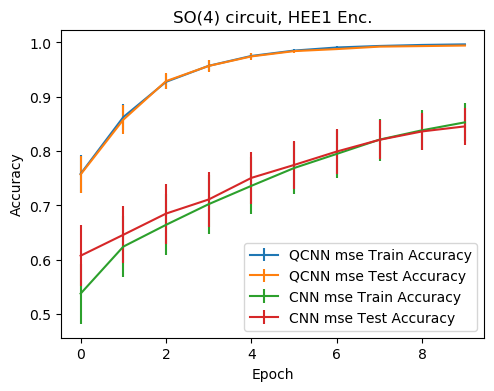

In [25]:
losses = ['mse']# ['hing', 'mse', 'xent']
Encs = ['HEE1']

for loss in losses:
    for Enc in Encs:
        epochs_range = range(epochs)
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.errorbar(epochs_range, mean_data[f'mean_acc_train_{loss}_{Enc}_QCNN_AllRuns'], yerr= std_data[f'std_acc_train_{loss}_{Enc}_QCNN_AllRuns'], label=f'QCNN {loss} Train Accuracy')
        plt.errorbar(epochs_range, mean_data[f'mean_acc_test_{loss}_{Enc}_QCNN_AllRuns'], yerr= std_data[f'std_acc_test_{loss}_{Enc}_QCNN_AllRuns'], label=f'QCNN {loss} Test Accuracy')
        plt.errorbar(epochs_range, mean_data[f'mean_acc_train_{loss}_{Enc}_CNN_AllRuns'], yerr= std_data[f'std_acc_train_{loss}_{Enc}_CNN_AllRuns'], label=f'CNN {loss} Train Accuracy')
        plt.errorbar(epochs_range, mean_data[f'mean_acc_test_{loss}_{Enc}_CNN_AllRuns'], yerr= std_data[f'std_acc_test_{loss}_{Enc}_CNN_AllRuns'], label=f'CNN {loss} Test Accuracy')
        plt.title(f'SO(4) circuit, {Enc} Enc.')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        
        plt.show()  


In [26]:
y_test_cnn

tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
        1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 

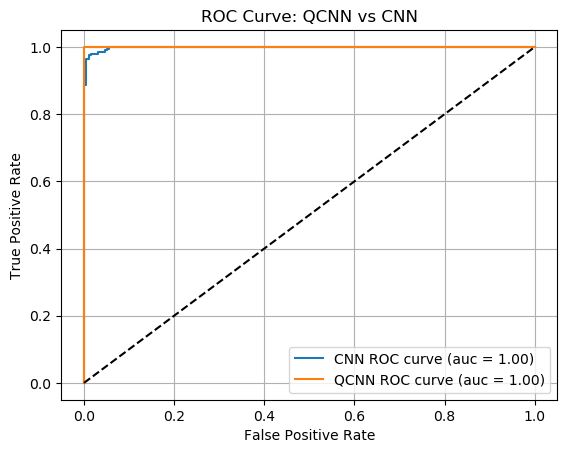

In [27]:
# compute ROC for CNN
fpr_cnn, tpr_cnn, thr = roc_curve(y_test_cnn, mean_data[f'mean_roc_{loss}_{suffix}_CNN_AllRuns'], pos_label=1)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

# compute ROC for QCNN
fpr_qcnn, tpr_qcnn, _ = roc_curve(y_test_qcnn, mean_data[f'mean_roc_{loss}_{suffix}_QCNN_AllRuns'], pos_label=1)
roc_auc_qcnn = auc(fpr_qcnn, tpr_qcnn)

plt.figure()
plt.plot(fpr_cnn, tpr_cnn, label=f'CNN ROC curve (auc = {roc_auc_cnn:.2f})')
plt.plot(fpr_qcnn, tpr_qcnn, label=f'QCNN ROC curve (auc = {roc_auc_qcnn:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: QCNN vs CNN')
plt.legend(loc="lower right")
plt.grid(True)
#plt.savefig(os.path.join(directory, f'roc_QCNN_CNN_SO4_{loss_QCNN.__name__}_{Enc.__name__}_run{i+Nrun}.png'))
#plt.close()
